# Injecting signals into TESS light curves.

In [1]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
import eleanor
from tqdm import tnrange, trange
from tess_rotation import *
import eleanor

import warnings
warnings.filterwarnings('ignore')

from scipy.interpolate import RectBivariateSpline

import requests
from astroquery.mast import Tesscut

from astropy.table import Table
from astropy.coordinates import SkyCoord

import re

import matplotlib.animation as animation

# For animation display
from matplotlib import rc
from IPython.display import HTML
rc('animation', html='jshtml')

# For bokeh plotting
from bokeh import plotting
plotting.output_notebook()

Loading BokehJS ...

In [2]:
south = pd.read_csv("../../data/cvz_south_16th.csv")

In [3]:
# star = eleanor.multi_sectors(tic=306469159, sectors=[1, 2])
# star = eleanor.Source(tic=272429282, sector=1, tc=True)

# ticid = "382627020"  # quiet star
ticid = "260354552"  # Previous CPM example.
ticid = "349061281"  # Flat CPM example.
star = eleanor.Source(tic=ticid, sector=1, tc=True)

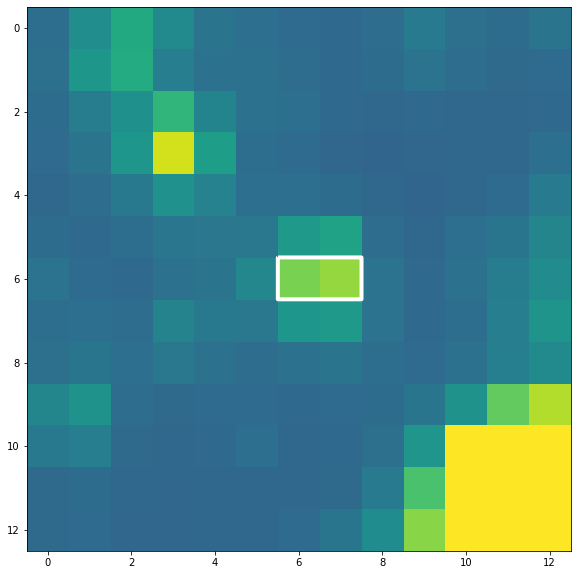

In [4]:
data = eleanor.TargetData(star)
q = data.quality == 0

vis = eleanor.Visualize(data)
vis.aperture_contour(vmin=0, vmax=300);

In [5]:
# print(data.aperture)

Load the TESScut cut out for this star.

In [6]:
# fits_image_filename = "/Users/rangus/projects/TESS-rotation/data/TESScut/astrocut_94.9608595415412_-55.9150480977925_68x68px" \
#                       "/tess-s0001-4-4_94.960860_-55.915048_68x68_astrocut.fits"
fits_image_filename = "/Users/rangus/projects/TESS-rotation/data/TESScut/astrocut_107.471456786207_-61.5366731480293_68x68px" \
    "/tess-s0001-4-3_107.471457_-61.536673_68x68_astrocut.fits"
with fits.open(fits_image_filename) as hdu1:
    hdu1.info()
    postcard = hdu1[1].data
    cols = hdu1[1].columns
    hdr = hdu1[0].header
print(cols)

Filename: /Users/rangus/projects/TESS-rotation/data/TESScut/astrocut_107.471456786207_-61.5366731480293_68x68px/tess-s0001-4-3_107.471457_-61.536673_68x68_astrocut.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1282R x 12C   [D, E, J, 4624J, 4624E, 4624E, 4624E, 4624E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (68, 68)   int32   
ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'RAW_CNTS'; format = '4624J'; unit = 'count'; null = -1; disp = 'I8'; dim = '(68, 68)'
    name = 'FLUX'; format = '4624E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(68, 68)'
    name = 'FLUX_ERR'; format = '4624E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(68, 68)'
    name = 'FLUX_BKG'; format = '4624E'; unit = 'e-/s'; disp = '

(1282, 68, 68)


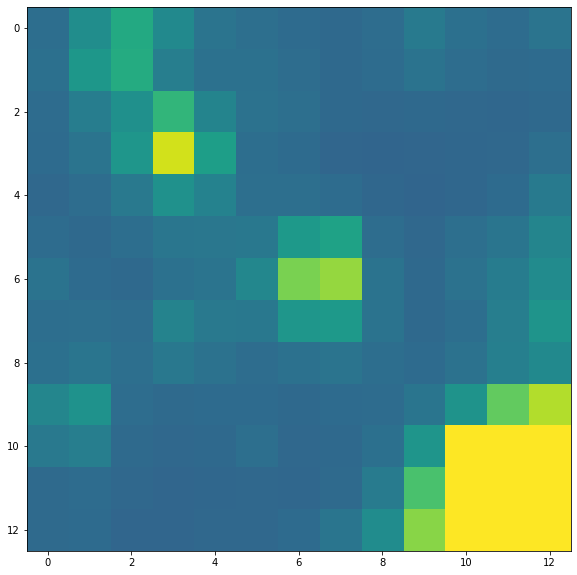

In [7]:
time = postcard["TIME"]*1.
flux = postcard["FLUX"]*1.
print(np.shape(flux))

# flux[0, 32:35, 33:36] += [[2000, 2000, 2000], [2000, 2000, 2000], [2000, 2000, 2000]]
# plt.imshow(flux[0, :, :], vmin=0, vmax=300)
plt.imshow(flux[0, 27:40, 28:41], vmin=0, vmax=300)
# plt.imshow(data.aperture*300, cmap="gray_r", alpha=.2)

Figure out how to inject the signal at the stars' centroid.

In [8]:
# signal = 300 + 50*np.sin(time*2*np.pi/4.8)  # simple sine wave, you can change it to something more realistic

In [9]:
# aperture_mask = data.aperture == 1.
# print(np.shape(aperture_mask[None, :, :]), np.shape(flux[0, 27:40, 28:41]))
# for i in range(len(time)):
#     plt.plot(time[i], flux[i, 27:40, 28:41][aperture_mask][0] + signal[i], "k.")
#     plt.plot(time[i], flux[i, 27:40, 28:41][aperture_mask][1] + signal[i], "C0.")

Print the Eleanor centroid.

In [10]:
print(star.sector, star.camera, star.chip, star.position_on_chip, star.locate_on_tess(), star.position_on_chip)

1 4 3 [1625  612] None [1639.28399742  627.65144243]


In [11]:
from tess_stars2px import tess_stars2px_function_entry

m = south.ID.values == int(ticid)
ra = south.ra.values[m]
dec = south.dec.values[m]
ticid = south.ID.values[m]
print("Tmag = ", south.Tmag.values[m])

outID, outEclipLong, outEclipLat, outSec, outCam, outCcd, outColPix, outRowPix, scinfo = \
    tess_stars2px_function_entry(int(ticid), ra, dec)
print(outColPix[0], outRowPix[0], outCcd[0], outCam[0], outSec[0])

Tmag =  [15.00290012]
1639.2839974213725 627.6514424285949 3 4 1


In [12]:
path = "https://archive.stsci.edu/missions/tess/models/prf_fitsfiles/"
prf = getPrfAtColRowFits(outColPix[0], outRowPix[0], outCcd[0], outCam[0], outSec[0], path)  # col, row, ccd, camera, sector
print(np.shape(prf))

(117, 117)


In [13]:
offset_y = 0.  # this should really be an array that tracks the row and column motions 
offset_x = 0.  # of the centroid of a star. You can calculate those yourself by taking a bright isolated star
                   # and calculating the center of mass at each cadence and dropping that in, or running eleanor and
                  # taking data.x_com (I think) would get you the same thing and you can drop in those offsets.

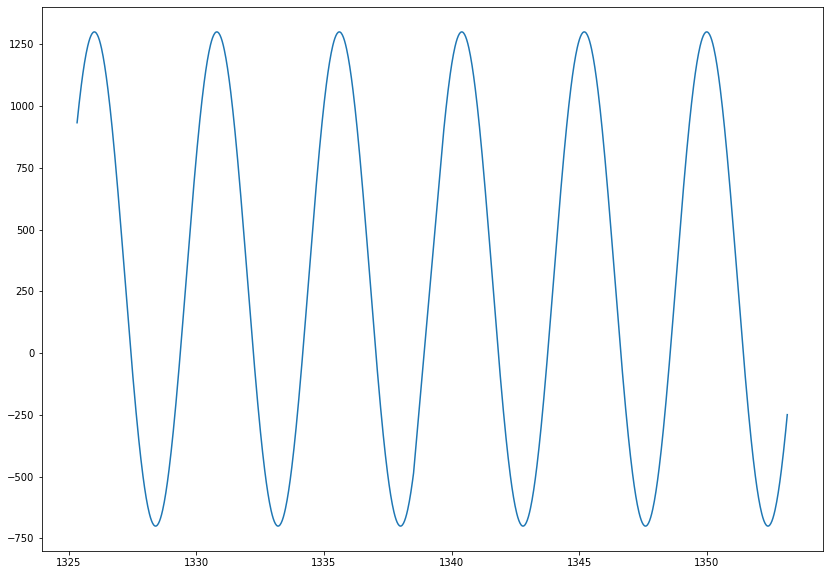

In [14]:
signal = 300 + 1000*np.sin(time*2*np.pi/4.8)  # simple sine wave, you can change it to something more realistic
plt.plot(time, signal)

In [15]:
# injected_flux = flux[:, 27:40, 28:41] + signal[:, None, None] * move_prf(prf, offset_x, offset_y)[None, :, :]
injected_flux = flux + signal[:, None, None] * move_prf(prf, offset_x, offset_y, npix=68)[None, :, :]

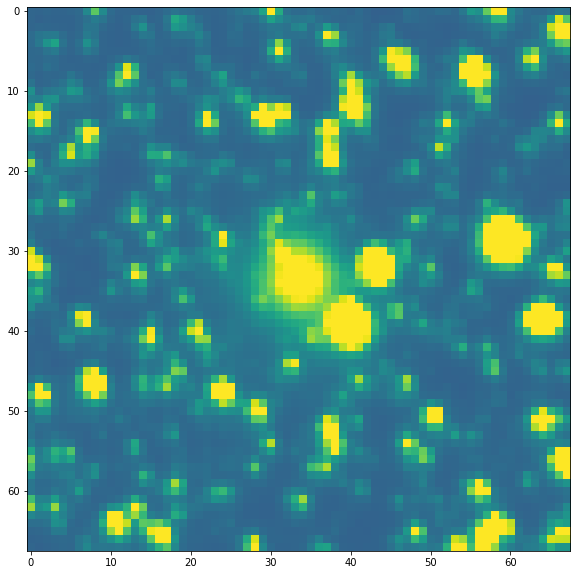

In [16]:
plt.imshow(injected_flux[0, :, :], vmin=0, vmax=300)

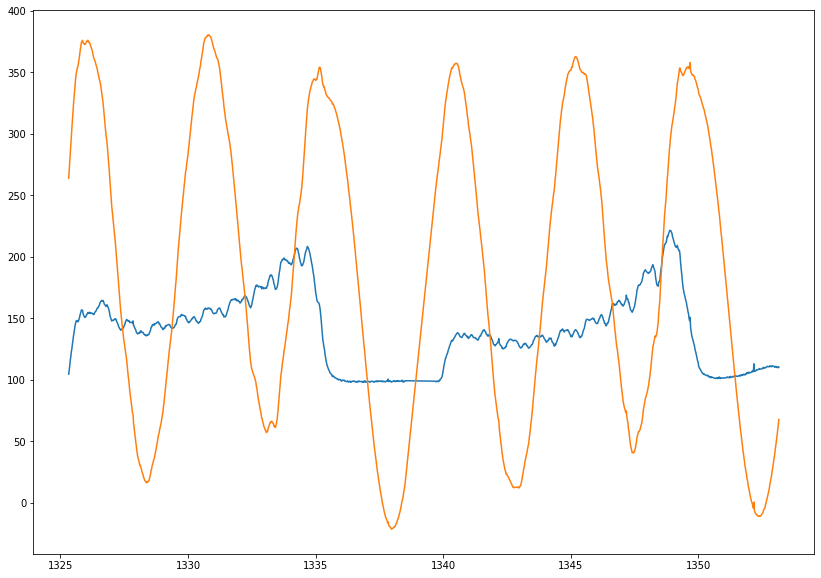

In [17]:
plt.plot(time, flux[:, 30, 34])
plt.plot(time, injected_flux[:, 30, 34])

In [ ]:
# This is the directory where MAST stores the prf FITS files.
path = "https://archive.stsci.edu/missions/tess/models/prf_fitsfiles/"
prf = getPrfAtColRowFits(939.361, 1095.571, 1, 4, 1, path)  # col, row, ccd, camera, sector

In [16]:
postflux = fits.open("/Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc/" \
                     "hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc.fits")

In [52]:
postcard = postflux[2].data + 0.0
time = postflux[1].data['tstart']
print(np.shape(postcard), np.shape(time))

(1282, 104, 148) (1282,)


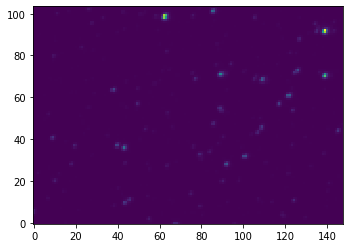

In [53]:
plt.imshow(postcard[0, :, :], origin='lower')

In [54]:
offset_y_1 = 0.5  # this should really be an array that tracks the row and column motions 
offset_x_1 = 0.7  # of the centroid of a star. You can calculate those yourself by taking a bright isolated star
                  # and calculating the center of mass at each cadence and dropping that in, or running eleanor and
                  # taking data.x_com (I think) would get you the same thing and you can drop in those offsets.
print(np.shape(move_prf(prf, offset_x_1, offset_y_1)))

(13, 13)


In [59]:
signal_1 = 300 + 56.0 * np.sin(time*2*np.pi/4.8)  # simple sine wave, you can change it to something more realistic
signal_2 = 10000 * np.ones_like(time)

postcard2 = postcard*1
postcard3 = postcard*1
postcard2[:, 63:76, 33:46] += signal_2[:, None, None]
postcard3[:, 63:76, 33:46] += signal_2[:, None, None] * move_prf(prf, offset_x_1, offset_y_1)[None, :, :]

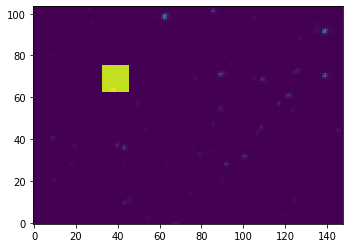

In [60]:
plt.imshow(postcard2[0, :, :], origin='lower')

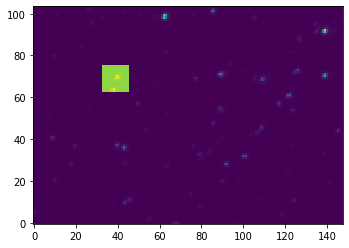

In [61]:
plt.imshow(postcard3[0, :, :], origin='lower')

In [ ]:
# postflux[2].data = postcard + 0.0
# postflux.close()

# Code for downloading eleanor light curves and postage stamps.

Inflating...
This is the first light curve you have made for this sector. Getting eleanor metadata products for Sector  3...
This will only take a minute, and only needs to be done once. Any other light curves you make in this sector will be faster.
Target Acquired
Cadences Calculated
Quality Flags Assured
CBVs Made
Success! Sector  3 now available.


In [29]:
print(star[0])
print('Found TIC {0} (Gaia {1}), with TESS magnitude {2}, RA {3}, and Dec {4}'
     .format(star[0].tic, star[0].gaia, star[0].tess_mag, star[0].coords[0], star[0].coords[1]))

data = eleanor.TargetData(star[0], height=15, width=15, bkg_size=31, do_psf=True, do_pca=True)

Found TIC 150428135 (Gaia 5284517766615492736), with TESS magnitude 10.9102, RA 97.0967865903209, and Dec -65.5793115481931


Set DATE-BEG to '2018-07-25T19:30:10.121' from MJD-BEG'. [astropy.wcs.wcs]
100%|██████████| 1282/1282 [00:11<00:00, 111.72it/s]


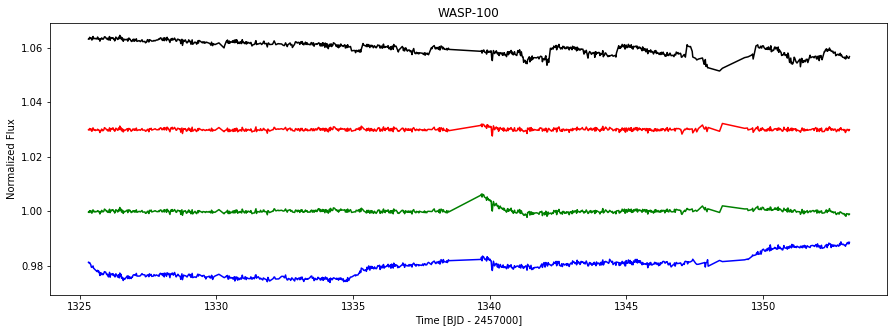

In [30]:
plt.figure(figsize=(15,5))

q = data.quality == 0

plt.plot(data.time[q], data.raw_flux[q]/np.nanmedian(data.raw_flux[q])+0.06, 'k')
plt.plot(data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q]) + 0.03, 'r')
plt.plot(data.time[q], data.pca_flux[q]/np.nanmedian(data.pca_flux[q]), 'g')
plt.plot(data.time[q], data.psf_flux[q]/np.nanmedian(data.psf_flux[q]) - 0.02, 'b')
plt.ylabel('Normalized Flux')
plt.xlabel('Time [BJD - 2457000]')
plt.title('WASP-100');